# IMA207 - Practical work on SAR statistics

### Emanuele DALSASSO, Florence TUPIN, Cristiano ULONDU MENDES, Thomas BULTINGAIRE

### Statistics and despeckling

The practical work is divided in 3 parts

- A. empirical checking of the distributions seen in course for synthetic speckle
- B. computation of equivalent number of looks using images of physically homogeneous areas
- C. spatial multi-looking and implementation of the Lee filter

You have at your disposal several images of various areas acquired by different acquisition modes.
- An oceanfront in São-Paulo acquired by Sentinel-1 sensor (ESA) in GRD (Ground Range Detected) mode
- A farmland near from Bologne (Italy) acquired by TerraSAR-X sensor (ESA) in MGD (Multi Look Ground Range Detected) mode
- An area near from Rome acquired by TerraSAR-X sensor (ESA) in SLC (Single Look Complex) mode
- A temporal stack of images acquired at Flevoland in Netherlands by Alos sensor (JAXA) in SLC mode

Some useful functions are available in the file *mvalab.py*.

### Name: **LAURA MANUELA CASTAÑEDA**

#### Instructions

To solve this practical session, answer the questions below. Then export the notebook with the answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file on e-campus by next week.

### Import the libraries and packages we are going to use
The following cell imports all that is going to be necessary for the practical work

In [1]:
# !wget https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py
import urllib.request

url = "https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py"
filename = "mvalab.py"
urllib.request.urlretrieve(url, filename)

('mvalab.py', <http.client.HTTPMessage at 0x1b3f7913490>)

In [2]:
import scipy
from scipy import signal
import scipy.signal
import scipy as spy
import scipy.fftpack
from scipy import ndimage
from scipy import special
from scipy import ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import mvalab as mvalab
from urllib.request import urlopen
import cmath

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.max_open_warning'] = 30

## A. Single look data distributions

In this part, we will simulate an SLC (Single Look Complex) SAR image representing an homogeneous area and analyze the pdfs of its intensity and phase.

#### Single look data simulation

According to the Goodman model, the real and imaginary parts of each pixel of an SLC SAR image are independent and identically distributed according to a Gaussian distribution centered and of variance equal to the reflectivity of the pixel divided by 2.\
Choose randomly a reflectivity value $R$ in the interval $[100, 200]$ and create a SLC SAR image of size $150\times 150$ representing an homogeneous area of reflectivity $R$.

Affichage d'une image reelle
plt.show dans visusar : image 150 x 150


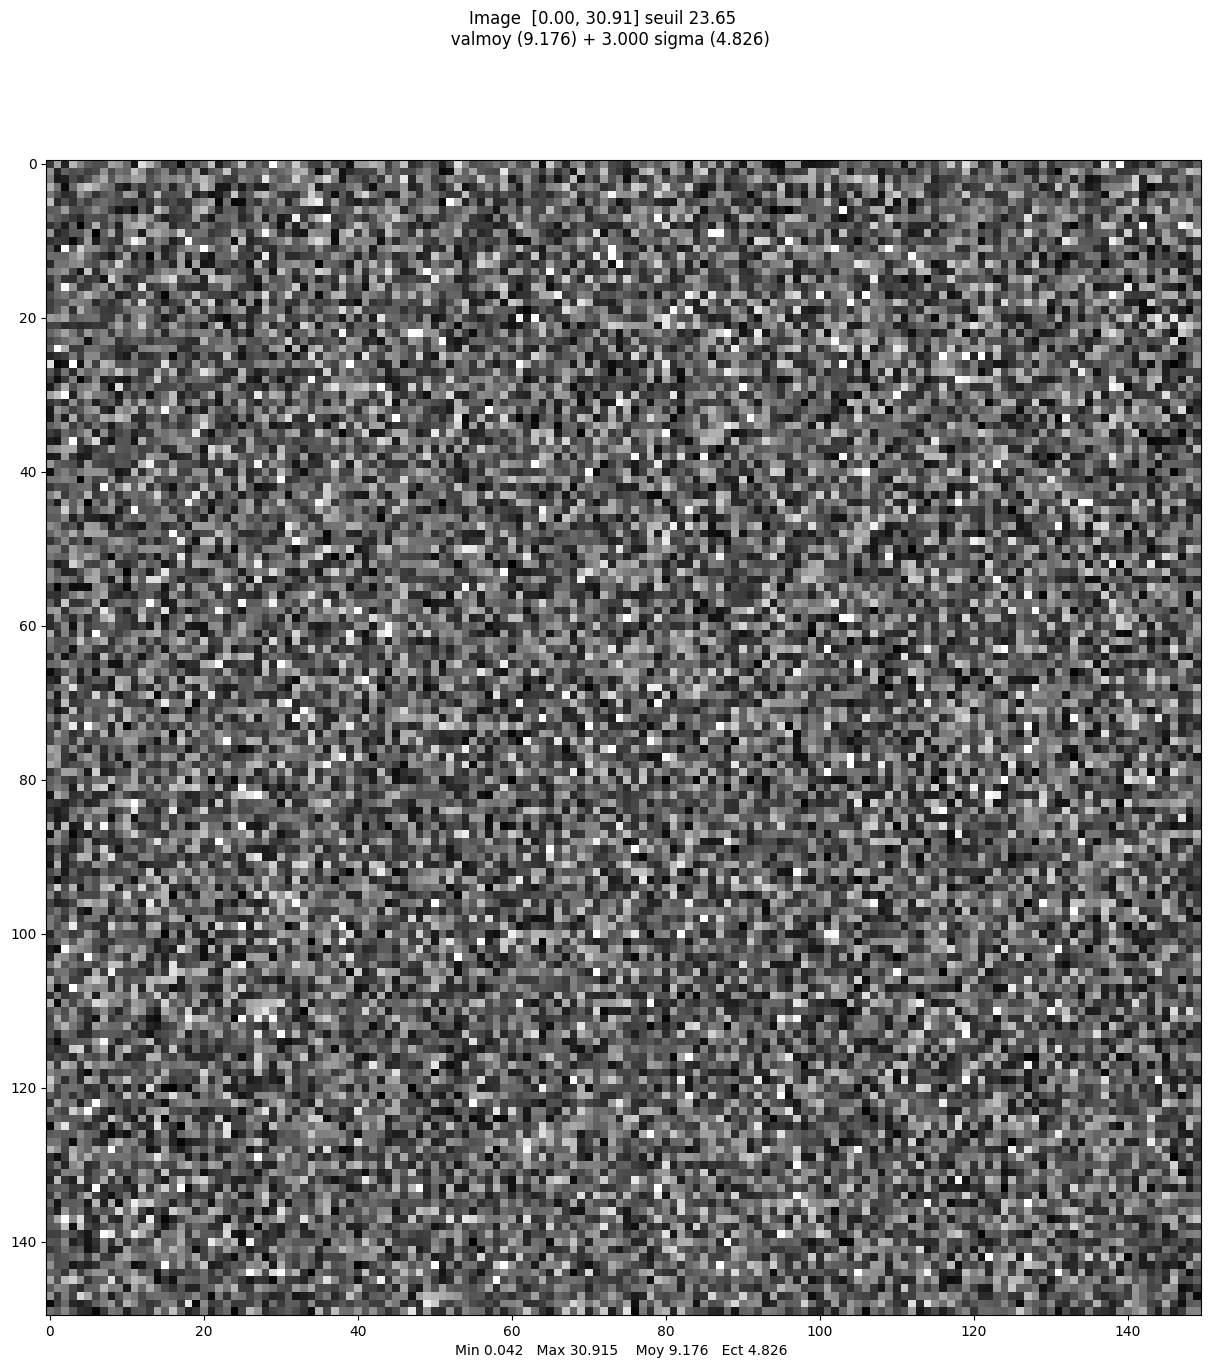

array([[ 5.4267741 , 14.93248584,  3.21483721, ...,  6.75524297,
         5.07400657,  8.58112174],
       [13.56462743,  3.48908976,  9.13185682, ..., 10.63044131,
        17.84640501, 15.79997789],
       [11.92081925,  2.62075761,  3.10744864, ..., 10.60931974,
         5.98668192,  9.65581525],
       ...,
       [13.5549967 ,  5.01400674, 11.45082153, ...,  2.82214222,
         9.61492432,  1.13947453],
       [ 0.91643168,  6.05819916,  9.93665985, ...,  1.49850337,
         8.31262924,  9.16169416],
       [10.49119943,  8.67933346, 12.49116472, ...,  5.91605058,
        12.21725743, 12.32332712]])

In [3]:
# Chose the reflectivity of the homogeneous area
R = np.random.uniform(100,200)

# Gaussian distributed real and imaginary parts with mean 0 and variance R/2
real_part = np.random.normal(0, np.sqrt(R / 2), (150, 150))
imaginary_part = np.random.normal(0, np.sqrt(R / 2), (150, 150))

# Combine real and imaginary parts into a complex SLC image
ima_slc = real_part + 1j * imaginary_part
mvalab.visusar(np.abs(ima_slc))

#### Data distributions for an homogeneous area

Compute the distribution of the phase and intensity of your image. Then, estimate the coefficient of variation: $\gamma=\frac{\sigma}{\mu}$ using intensity data (square of the modulus of the complex field)

In [4]:
# Compute the intensity and the phase
ima_int = abs(ima_slc)**2
ima_ph = np.angle(ima_slc)

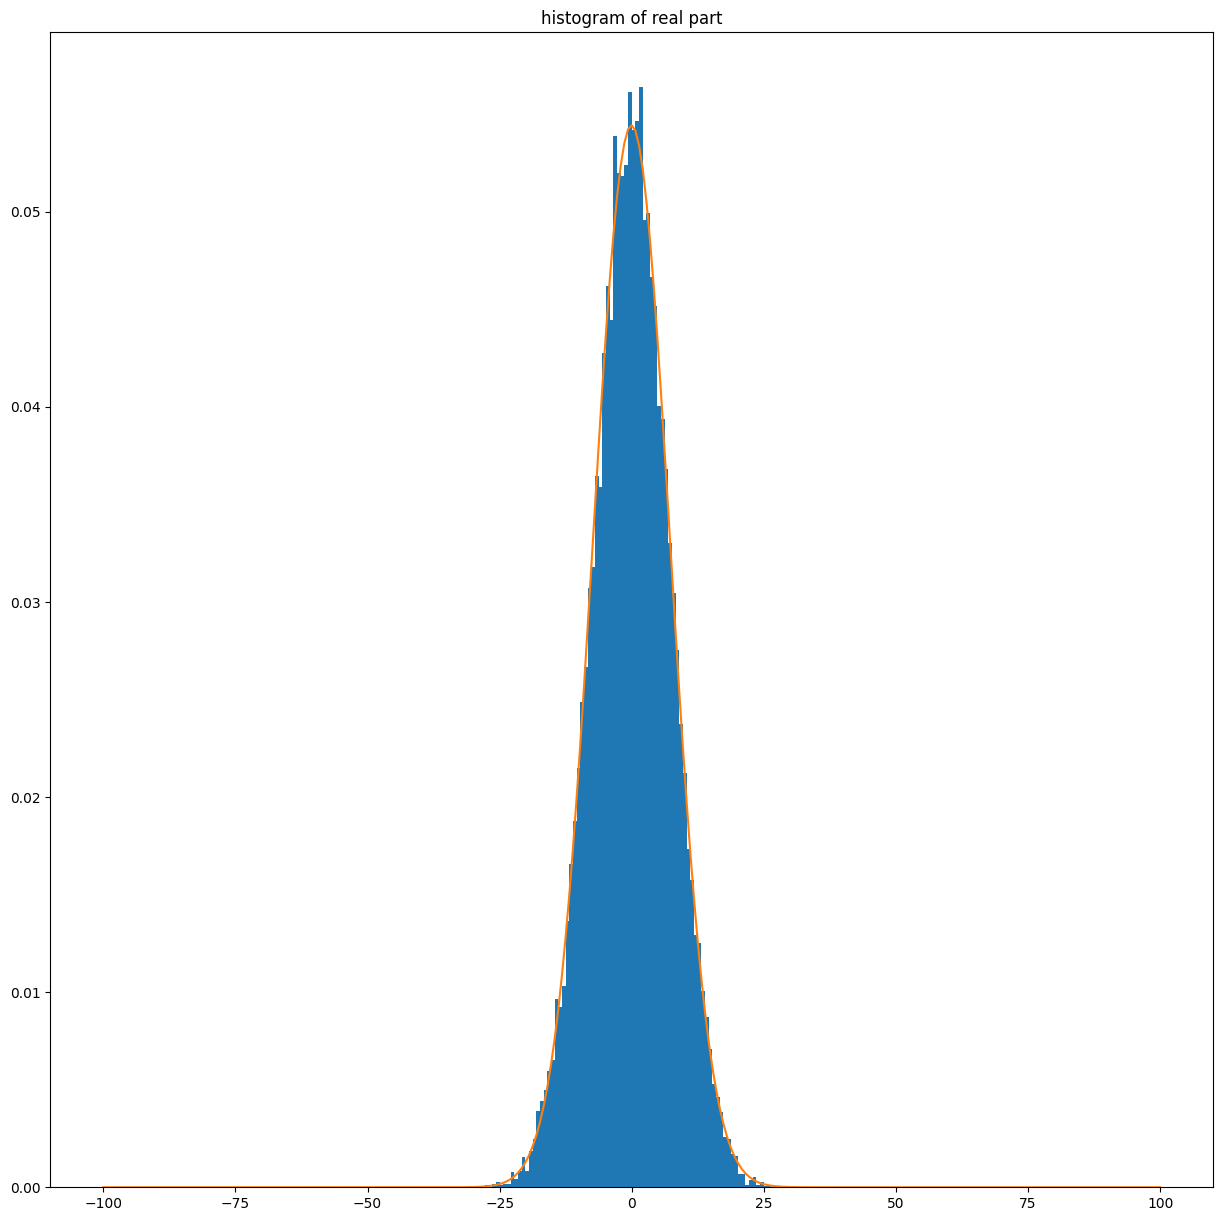

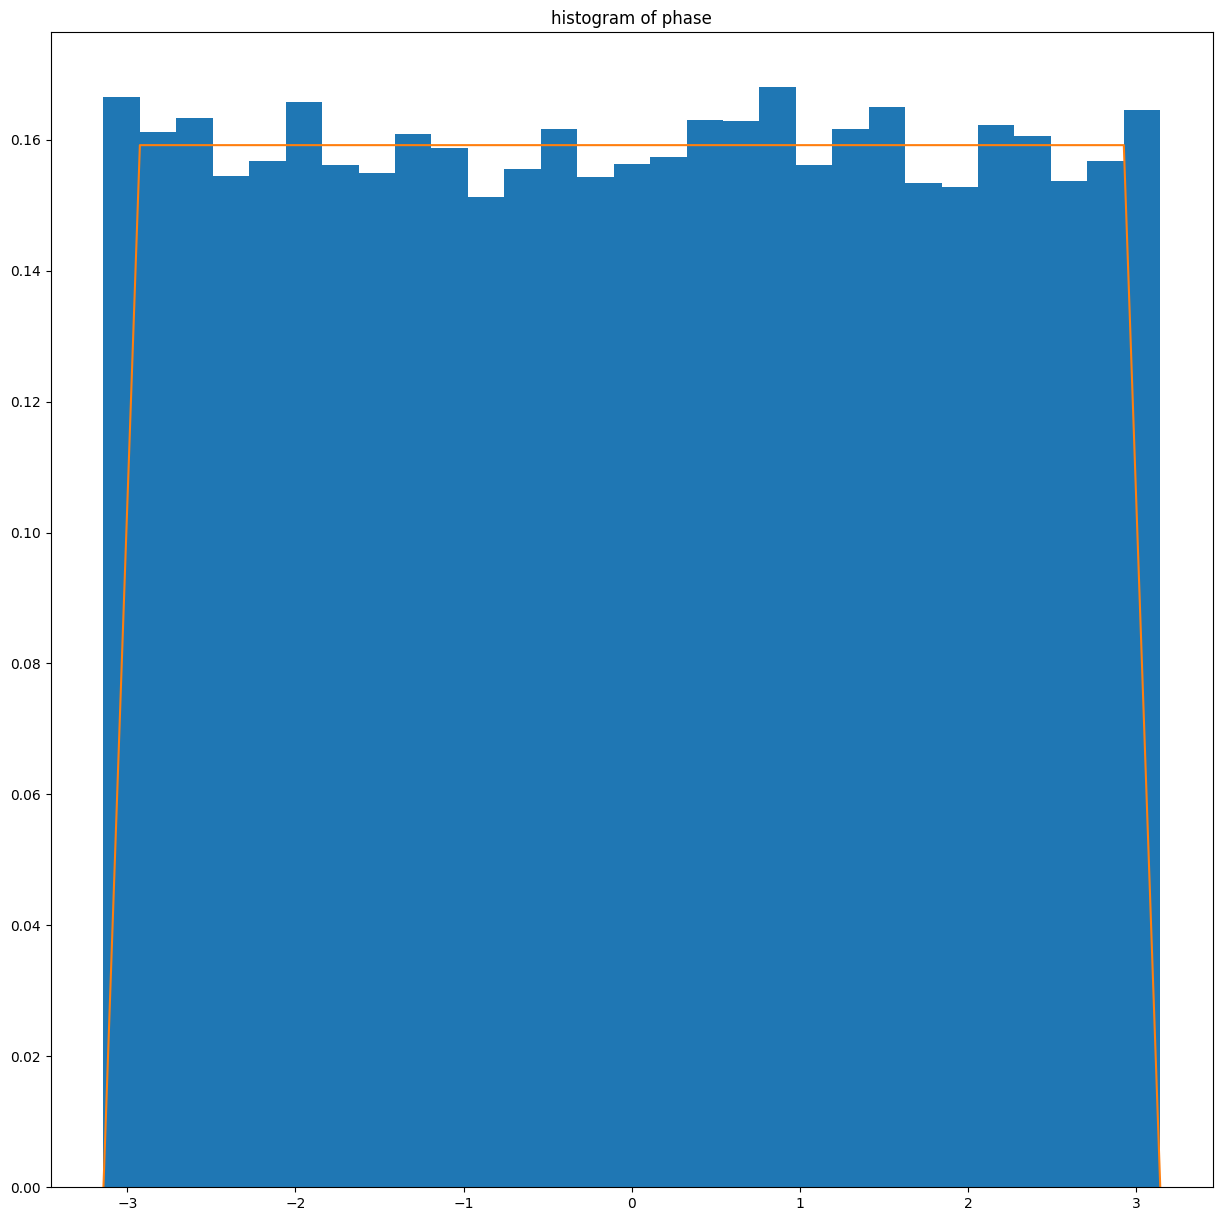

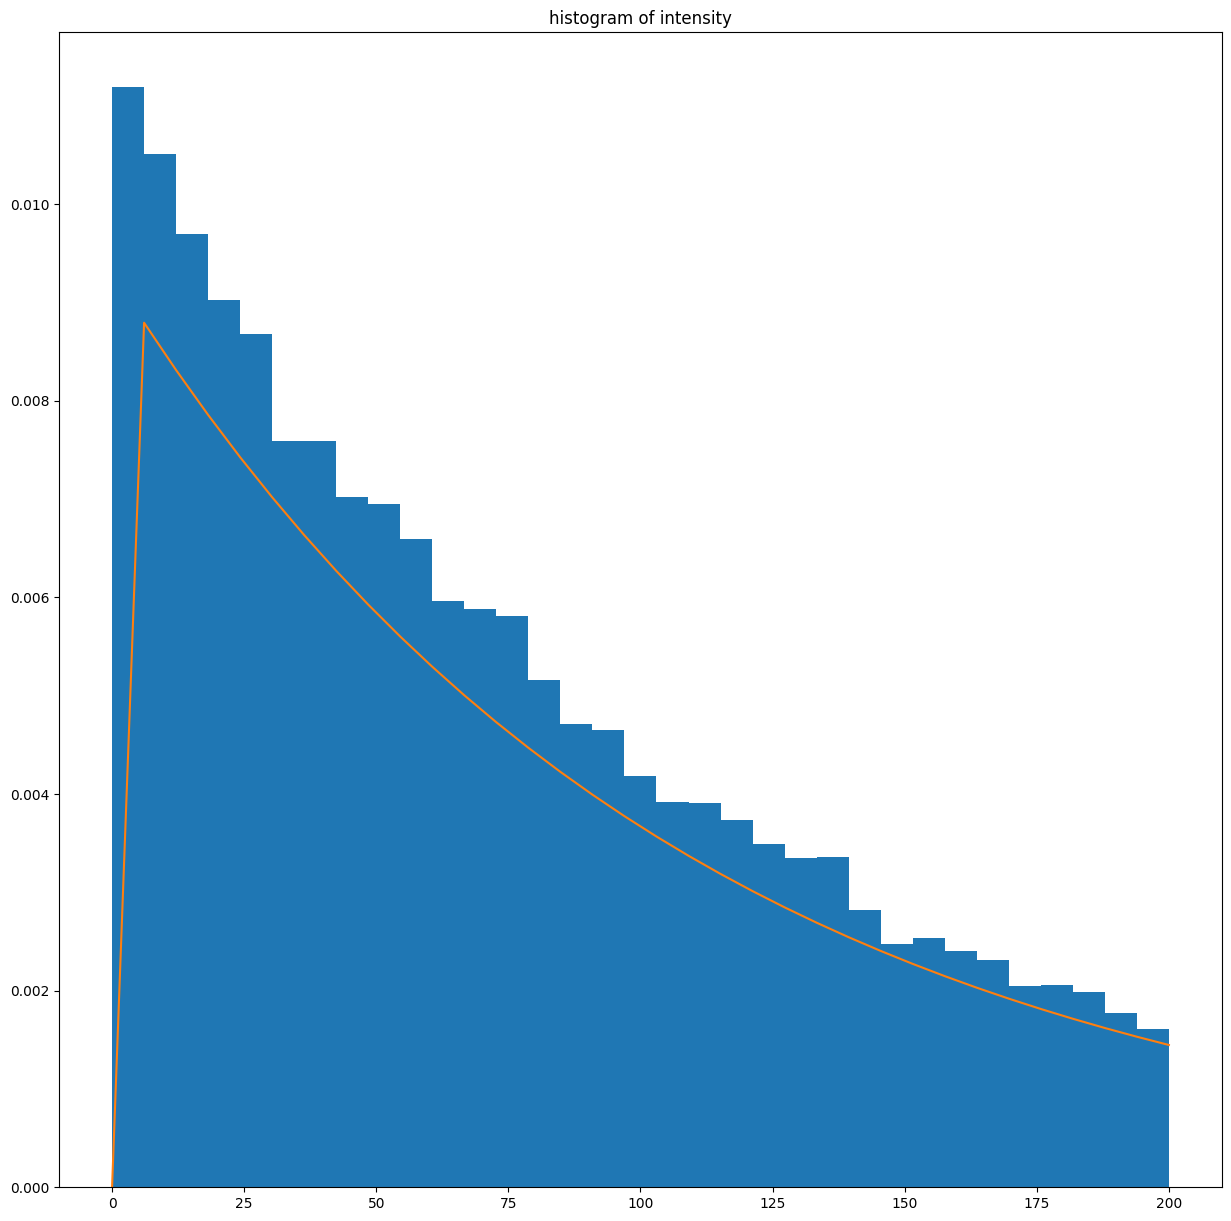

In [5]:
# Plot the histograms and verify they match the theoretical distribution
# Use the right range of values to plot the histogram
# Choose the right distribution to do the fitting

# fitting of the distributions
# use the following ones :
# Gaussian pdf : scipy.stats.uniform
# Rayleigh pdf : scipy.stats.rayleigh
# Exponential pdf : scipy.stats.expon

#example for real part of the data
plt.figure()
_, bins, _ = plt.hist(np.real(ima_slc).ravel(),bins='auto',density=True,range=[-100,100])  # Gaussian distribution
mu, sigma = scipy.stats.norm.fit(np.real(ima_slc))
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('histogram of real part')
plt.show()


#complete for phase data: Uniform distribution
plt.figure()
_, bins, _ = plt.hist(ima_ph.ravel(),bins='auto',density=True,range=[-np.pi, np.pi])  # Gaussian distribution
mu, sigma = scipy.stats.uniform.fit(ima_ph.ravel())
best_fit_line = scipy.stats.uniform.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('histogram of phase')
plt.show()


#complete for intensity data: Exponential (Gamma) distribution
plt.figure()
_, bins, _ = plt.hist(ima_int.ravel(),bins='auto',density=True,range=[0,200])  # Gaussian distribution
mu, sigma = scipy.stats.expon.fit(ima_int.ravel())
best_fit_line = scipy.stats.expon.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('histogram of intensity')
plt.show()

In [6]:
# Compute the coefficient of variation on the homogeneous area in intensity

m_I = np.mean(ima_int)
sigma_I = np.std(ima_int)
coeff_var_I = sigma_I/m_I
print(coeff_var_I)

1.0015216142157406


### Question A.1.

Did you find the distributions seen in the course ? (recapitulate them).
Did you find the correct value for the coefficient of variation ? Could this coefficient be less than the theoretical value ?

### Answer A.1.


## B. Computation of the Equivalent Number of looks on homogeneous areas
In this part you have at your disposal 2 images of a part a ocean (São-Paulo) and a part of a field (Bologne, Italy). The first is acquired by Sentinel-1 GRD, and the second by TerraSAR-X GRD. The multi-looking has been done by the data provider (ESA, European Space Agency).

Use the value of the coefficient of variation to find the Equivalent Number of Looks (ENL) of the Sentinel-1 GRD and TerraSAR-X GRD data.
The formula is :
- $\gamma_I=\frac{1}{\sqrt{L}}$ for intensity data

In [7]:
# Download the images
# !wget "https://partage.imt.fr/index.php/s/M3yeW5ozcsHyigR/download/s1_grd_saopaulo.npy"
# !wget "https://partage.imt.fr/index.php/s/TTRfS6XKCzSM6cS/download/tsx_grd_bologne.npy"

url = "https://partage.imt.fr/index.php/s/M3yeW5ozcsHyigR/download/s1_grd_saopaulo.npy"
filename = "s1_grd_saopaulo.npy"
urllib.request.urlretrieve(url, filename)

url = "https://partage.imt.fr/index.php/s/TTRfS6XKCzSM6cS/download/tsx_grd_bologne.npy"
filename = "tsx_grd_bologne.npy"
urllib.request.urlretrieve(url, filename)

('tsx_grd_bologne.npy', <http.client.HTTPMessage at 0x1b39738c190>)

Affichage d'une image reelle
plt.show dans visusar : image 250 x 250


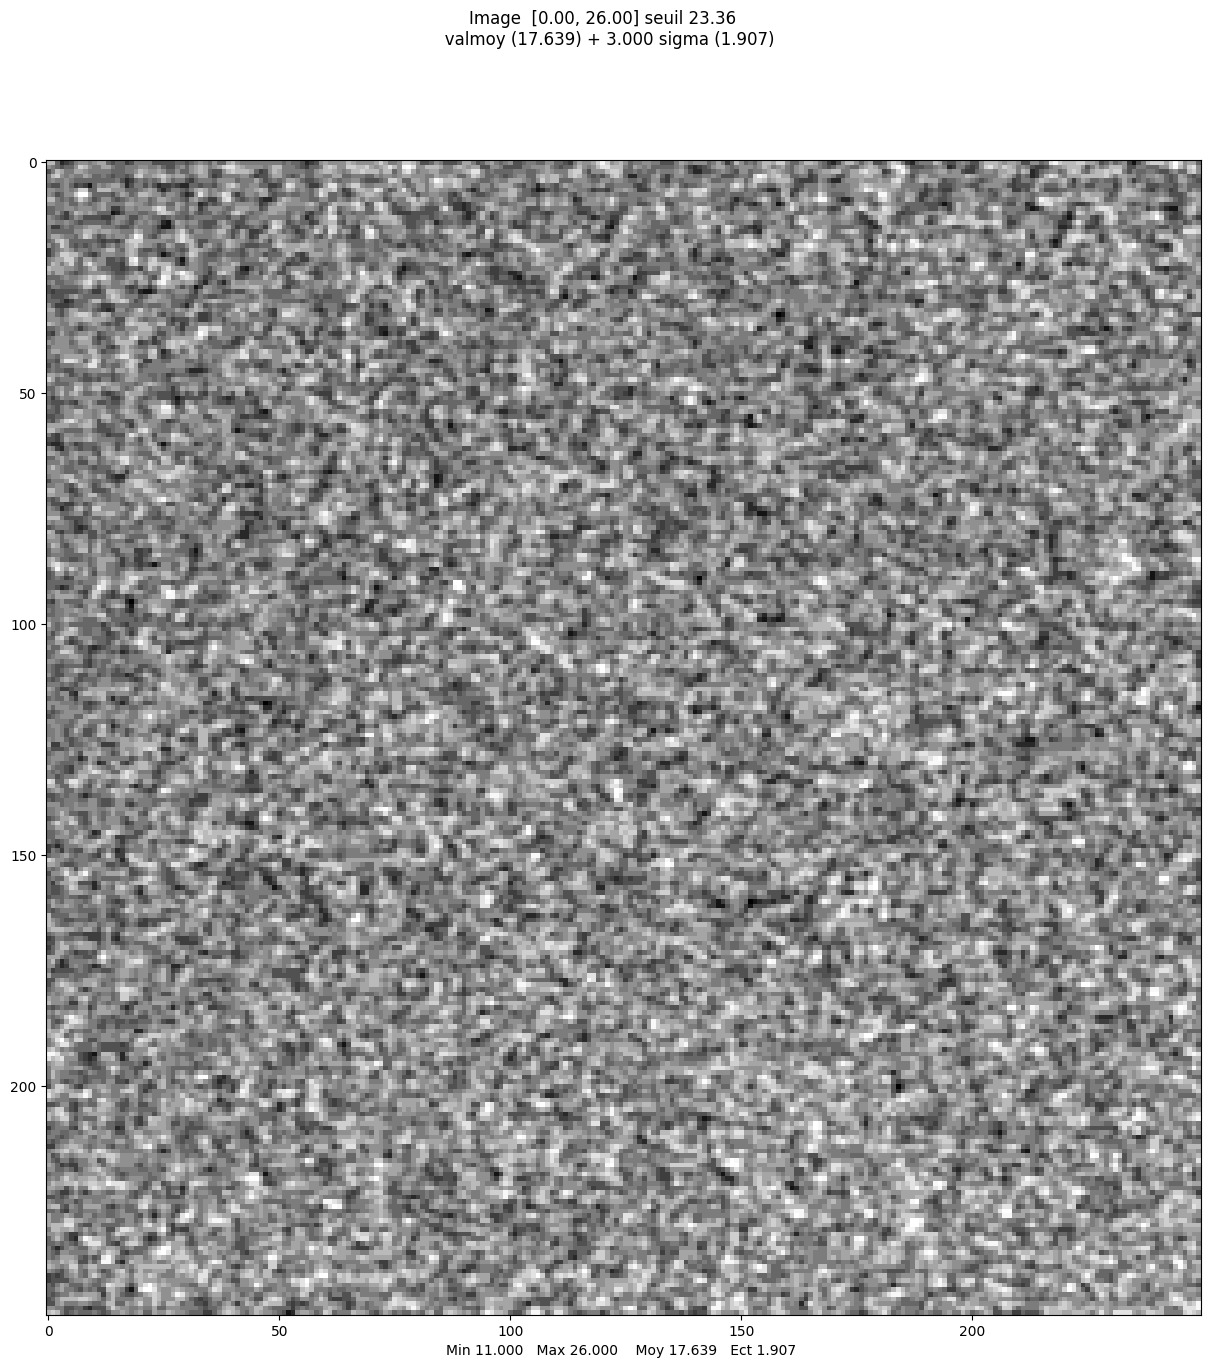

--- coeff var and L ---
0.10808459
85.59974031065106


In [8]:
im_s1grd = np.load("s1_grd_saopaulo.npy").astype(np.float32) #amplitude
im_s1grd_mer = im_s1grd[50:300, 100:350]
mvalab.visusar(im_s1grd_mer)

# compute coefficient of variation and number of looks
coeff_var_grd = (np.std(im_s1grd_mer)/np.mean(im_s1grd_mer))
L_grd = 1/coeff_var_grd**2
print('--- coeff var and L ---')
print(coeff_var_grd)
print(L_grd)

Affichage d'une image reelle
plt.show dans visusar : image 250 x 250


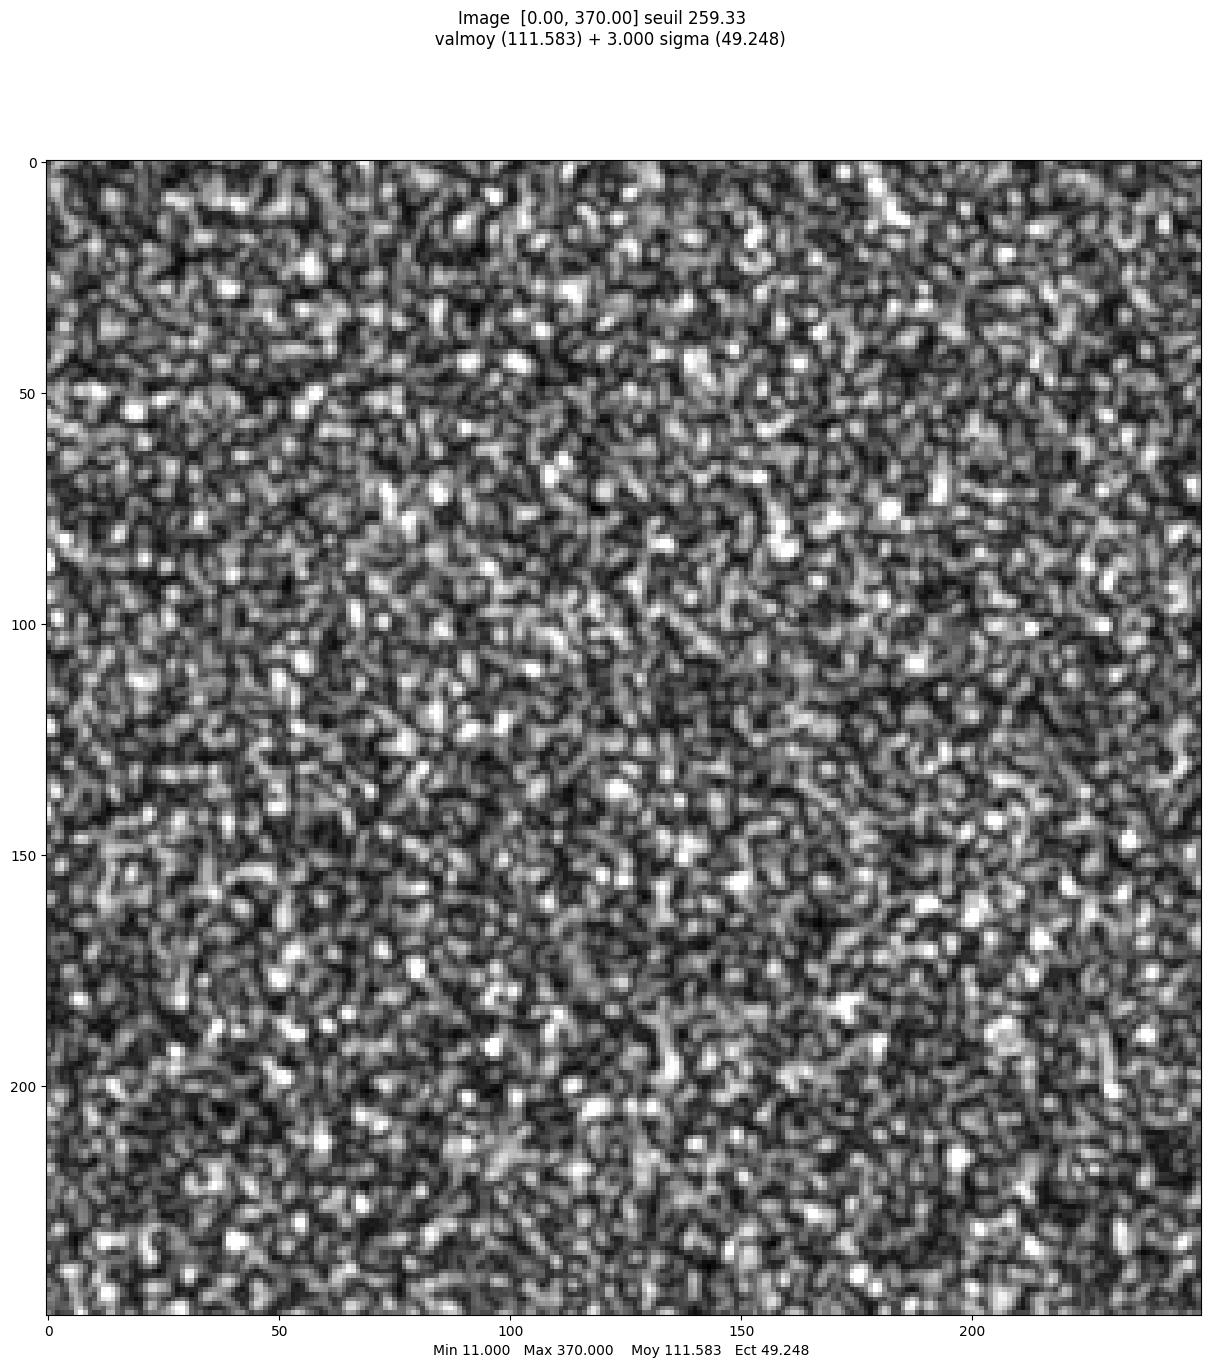

--- coeff var and L ---
0.44135696
5.133576601172019


In [9]:
im_tsxgrd = np.load("tsx_grd_bologne.npy").astype(np.float32) #amplitude
im_tsxgrd_champ = im_tsxgrd[700:950, 300:550]
mvalab.visusar(im_tsxgrd_champ)

# compute coefficient of variation and number of looks
coeff_var_grd = (np.std(im_tsxgrd_champ)/np.mean(im_tsxgrd_champ))
L_grd = 1/coeff_var_grd**2
print('--- coeff var and L ---')
print(coeff_var_grd)
print(L_grd)

### Question B.1
Comment the number of looks you have found for GRD date from Sentinel-1 and TerraSAR-X (is it an integer value ? why not ? what does it mean ?).

### Answer B.1

## C. Spatial multi-looking and implementation of the Lee filter

In this part we will try simple speckle reduction method using the following step :
- first we will compute a mean filter
- then we will compute the local coefficient of variation (using the same size for the moving window)
- finally we will combine these two results to obtain the Lee filter.

## C.1 Computation of the mean filter
Compute the mean filter using a 2D convolution.

In [10]:
# Download the image
# !wget "https://partage.imt.fr/index.php/s/cbRqjnSJEfD2zJ8/download/tsx_slc_rome.npy"

url = "https://partage.imt.fr/index.php/s/cbRqjnSJEfD2zJ8/download/tsx_slc_rome.npy"
filename = "tsx_slc_rome.npy"
urllib.request.urlretrieve(url, filename)

('tsx_slc_rome.npy', <http.client.HTTPMessage at 0x1b400d51450>)

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


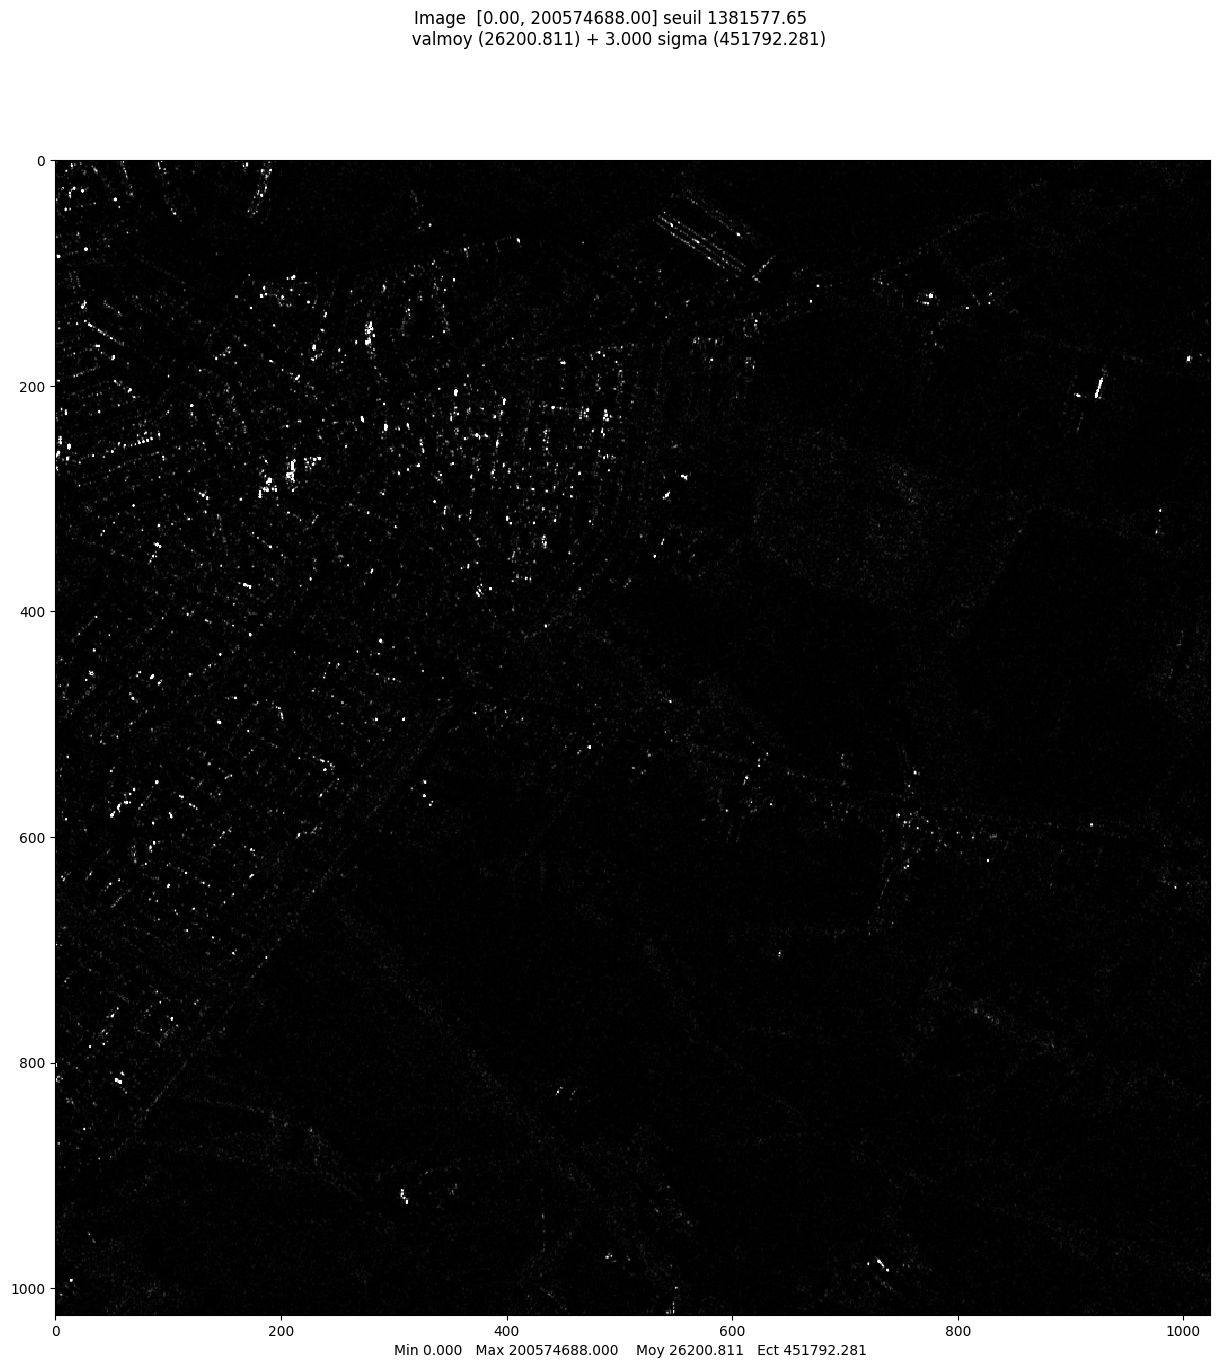

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


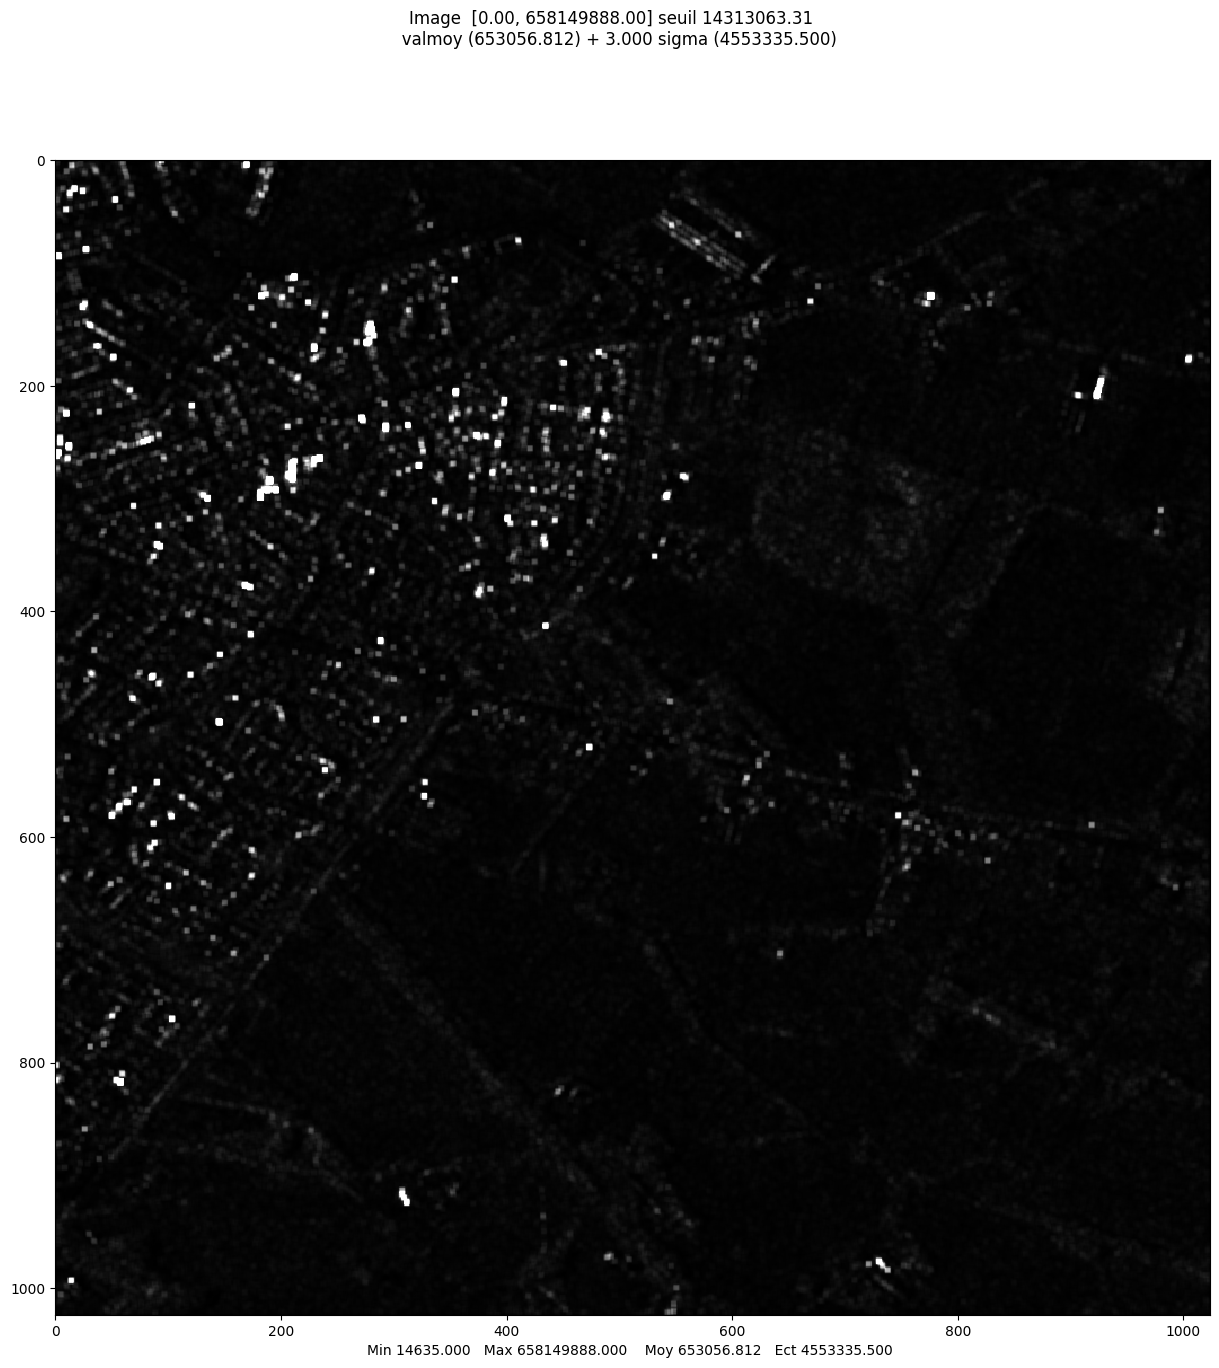

array([[1496873., 1516450., 1525234., ...,   87032.,   51828.,   37775.],
       [1635860., 1657005., 1667713., ...,   96986.,   60565.,   41030.],
       [1744693., 1767607., 1780165., ...,  109528.,   70553.,   45217.],
       ...,
       [ 110576.,  146353.,  171986., ...,  272826.,  240706.,  234744.],
       [ 101586.,  133782.,  155811., ...,  193010.,  163598.,  158028.],
       [  76701.,   96487.,  117335., ...,  113904.,   98636.,   94924.]])

In [11]:
ima_tsxslc = np.load("tsx_slc_rome.npy") #amplitude

# take the intensity
ima_int = np.abs(ima_tsxslc)**2
mvalab.visusar(ima_int)

# create the average window
size_window = 5
mask_loc = np.ones((size_window, size_window))

# compute the mean image (intensity data)
ima_int_mean = ndimage.convolve(ima_int, mask_loc, mode='constant', cval=0.0)

# display the result
mvalab.visusar(ima_int_mean)

### Question C.1
What is the effect of the mean filter ? (advantages and drawbacks). What is the influence of the window size ?

### Answer C.1

## C.2 Lee filter

Given a neighborhood, the Lee filter of an image $I_s$ can be computed by the following steps:

*   Compute the local mean of the image $\hat{\mu}_{s}$
*   Compute $k_s$ given by:
$$
  k_s=1- \frac{\gamma_{Sp}^2}{\hat{\gamma}_s^2}
$$
where $\gamma_{Sp}$ is the theoretical value of the coefficient of variation for a pure speckle ($\gamma_{Sp}=\frac{1}{\sqrt{L}}$ for a L-look intensity image), and $\hat{\gamma}_s$ is the empirical value of the coefficient of variation for the given neighborhood.
*   Compute the final filtered image
$$
  \hat{I}_s= \hat{\mu}_{s}+k_s (I_s-\hat{\mu}_{s})
$$

Create a function performing Lee filter on an image, for a given neighborhood and number $L$ of look.

Then, knowing that a SLC image is a 1-look image, compute the Lee filter on the intensity image of "ima_tsxslc"

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


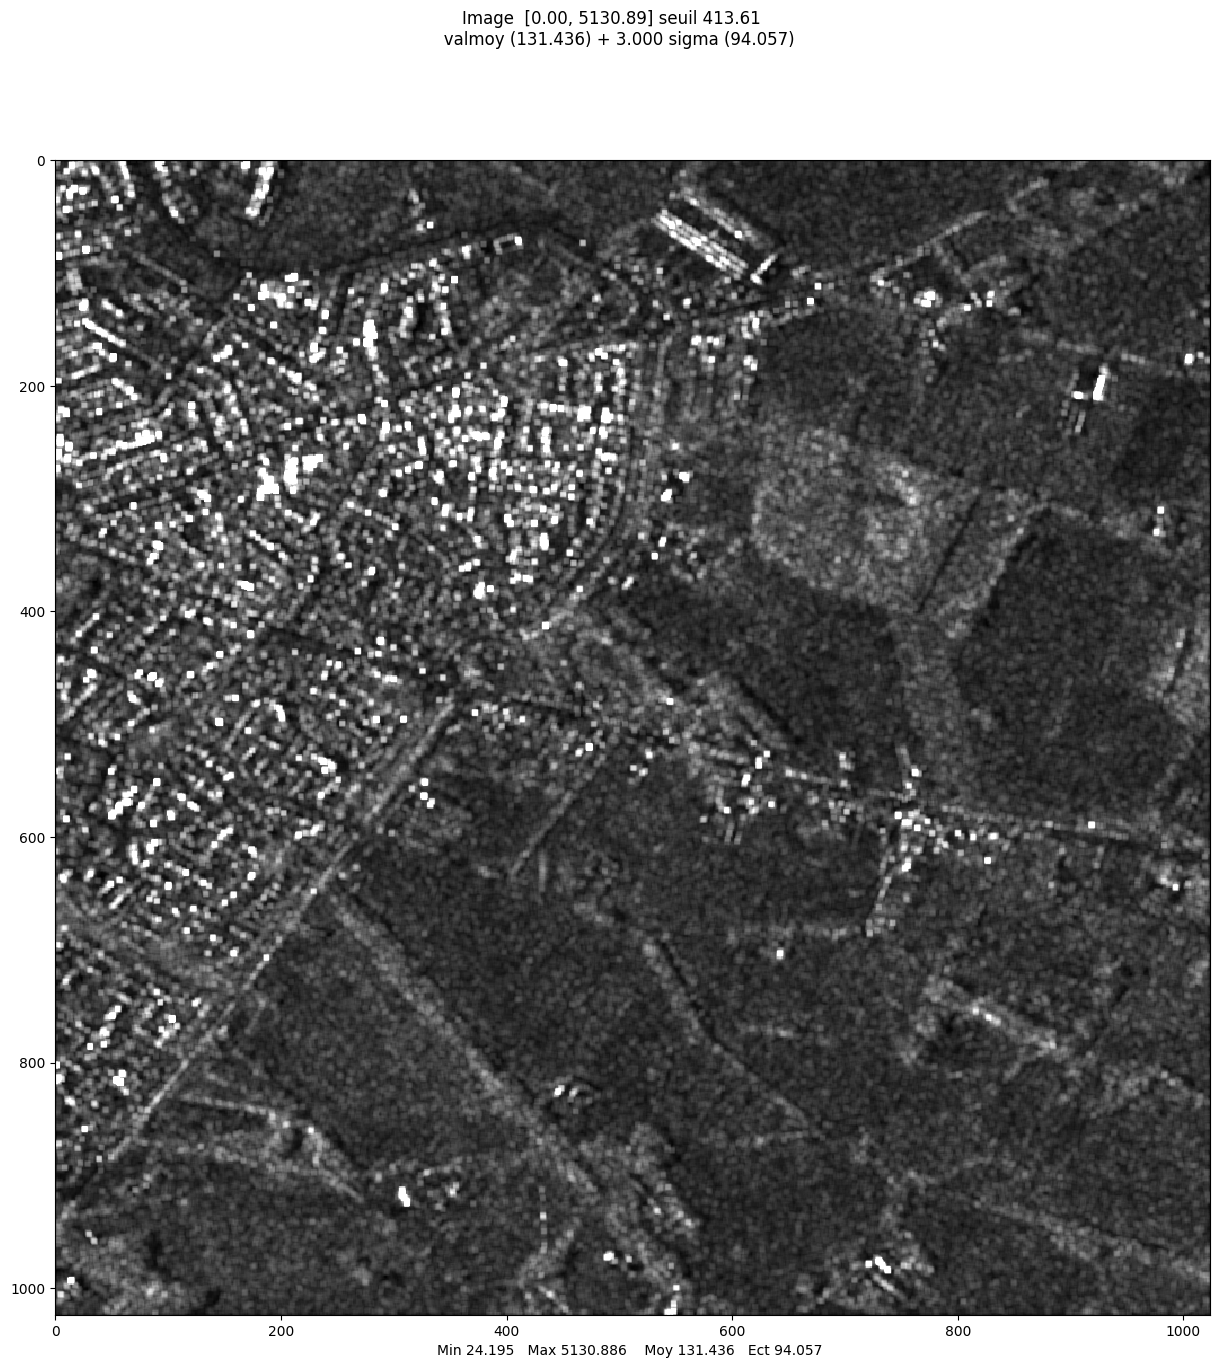

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


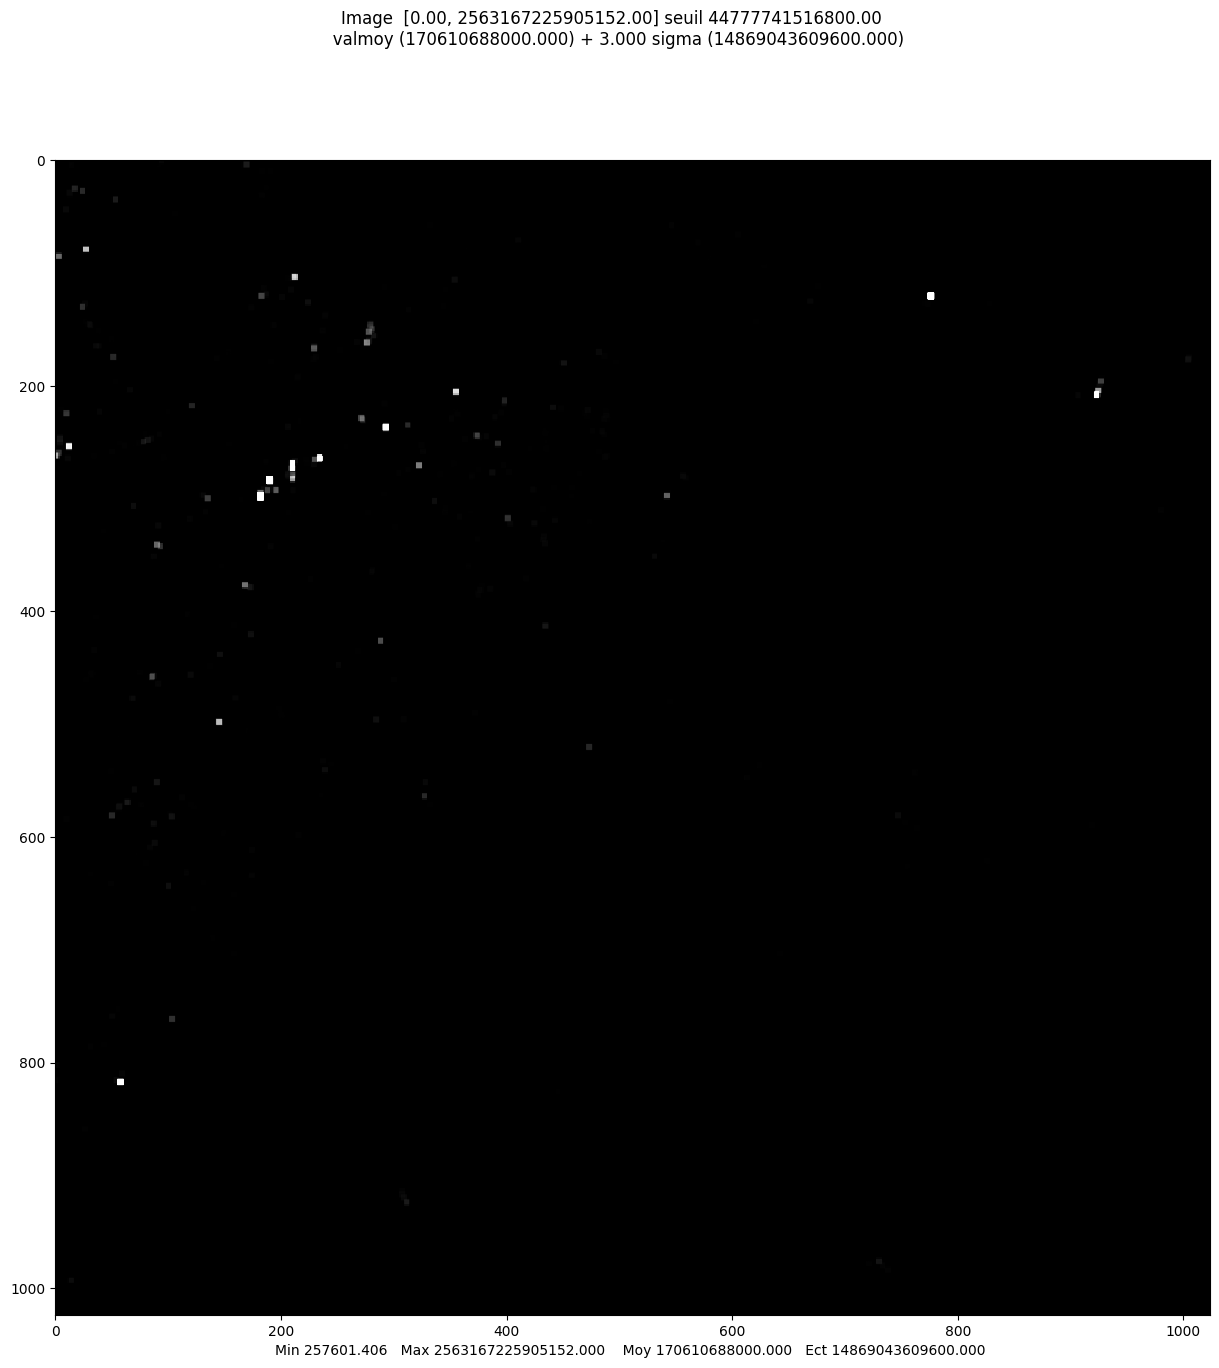

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


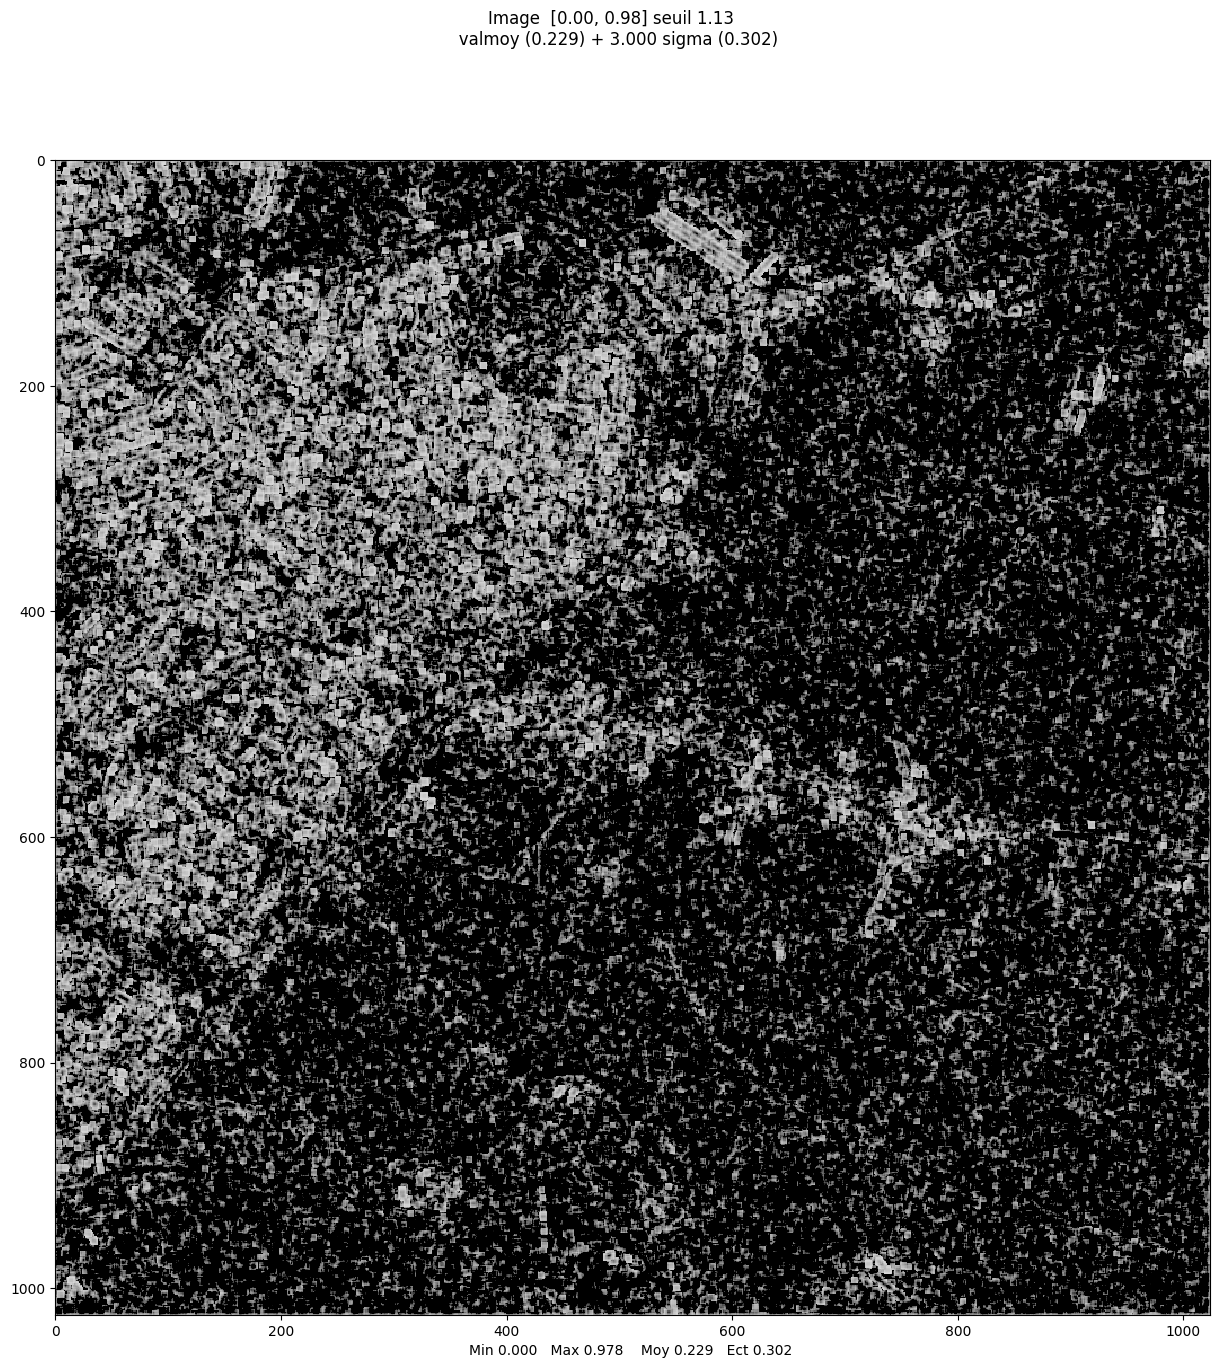

Affichage d'une image reelle
plt.show dans visusar : image 1024 x 1024


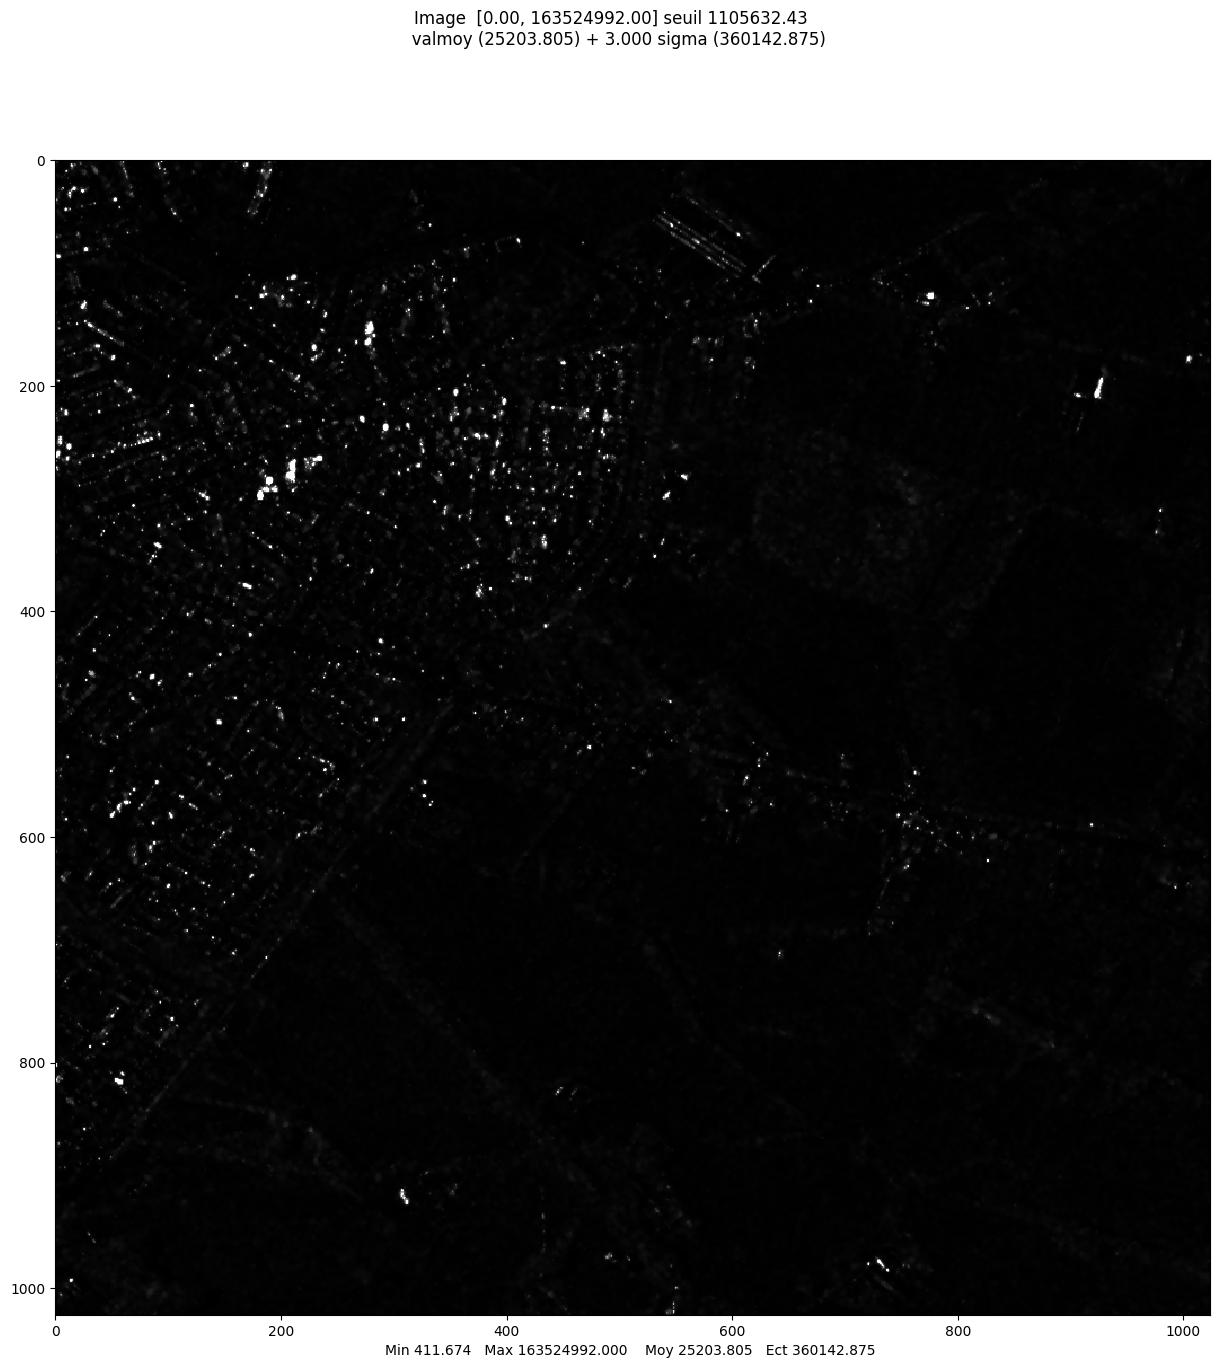

array([[ 31828.26367188,  92139.703125  , 207378.953125  , ...,
          3997.81933594,   6496.98144531,  12766.91699219],
       [ 48077.7421875 , 159978.75      , 183330.84375   , ...,
          2396.51489258,   3821.12890625,    904.31652832],
       [ 64655.11328125, 201991.296875  , 112624.703125  , ...,
          3290.88769531,   1894.82019043,    831.67840576],
       ...,
       [  6234.59277344,   5854.12011719,   6879.43994141, ...,
         10913.04003906,  10228.76367188,   6563.42919922],
       [  5717.9453125 ,   5605.47753906,   6232.43994141, ...,
          8918.07226562,   5631.78955078,  10301.45410156],
       [  3023.72460938,   3620.24609375,   5705.32568359, ...,
          7540.41894531,   2567.27880859,  11744.51367188]])

In [12]:
def lee_filter(im, neighborhood=7, L=1, visualize=False):

  # Mask
  mask = np.ones((neighborhood, neighborhood))

  # Compute local mean image
  im_mean = ndimage.convolve(im, mask, mode='constant', cval=0.0) / neighborhood**2

  # Compute local coefficient of variation (thanks to local variance and local mean)
  im_var = ndimage.convolve(im**2, mask, mode='constant', cval=0.0) / neighborhood**2 - im_mean**2
  
  im_std = np.sqrt(im_var)
  local_gamma_s = im_std / (im_mean + 1e-10)  # Adding small value to avoid division by zero

  # Theoretical coefficient of variation for speckle
  gamma_Sp = 1 / np.sqrt(L)

  # Compute scaling factor ks
  ks = 1 - (gamma_Sp / (local_gamma_s + 1e-10))**2  # Ensuring no division by zero
  ks = np.clip(ks, 0, 1)

  # Compute Lee filter
  filtered_im = im_mean + ks * (im - im_mean)

  # Visualizations
  if visualize:
    mvalab.visusar(np.sqrt(im_mean))
    mvalab.visusar(im_var)
    mvalab.visusar(np.sqrt(ks))

  return filtered_im


lee_filtered_int = lee_filter(ima_int, neighborhood=5, L=1, visualize=True)
mvalab.visusar(lee_filtered_int)

### Question C.2
Which information is enhanced in the image of the local standard deviation ? In the image of the local coefficient of variation ? Which one is the more useful ?

### Answer C.2

### Question C.3

Compare the results of the mean filter and the Lee filter. Study the influence of the size of the window of the filters.


### Answer C.3

## Filtering of image "Lely" and comparison with a deep learning algorithm
In this part, we will repeat the process done above to denoise a crop of image "Lely" using the Lee filter. Then, we will compare it with the result of a deep learning algorithm called SAR2SAR (https://arxiv.org/abs/2006.15037).

## C.4 Denoised image: SAR2SAR
The Lee filter presents some limits. More recent approaches to suppress noise rely on sofisticated algorithms. You can plot the image of Lely denoised using a deep learning algorthm called SAR2SAR and compare visually the result with the image filtered using the Lee filter.
  

In [13]:
# Download the image
# !wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA
# !wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim

url = "https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA"
filename = "lely_tuple_multitemp.IMA"
urllib.request.urlretrieve(url, filename)

url = "https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim"
filename = "lely_tuple_multitemp.dim"
urllib.request.urlretrieve(url, filename)

('lely_tuple_multitemp.dim', <http.client.HTTPMessage at 0x1b4003c7a50>)

imz2mat : version janvier 2018.  Fichier à ouvrir : lely_tuple_multitemp.IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
Dans ximaread : lecture du canal 0/25
image en .IMA
image en .IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
image en .ima  512   512   canaux: 25  verif :  1
512 512
-type CFLOAT
lecture de  lely_tuple_multitemp.IMA  en quelconque 512 512 25  offset  0 <f 4  complex 1 blocksize 2097152
Boucle de lecture entre 0 et 25   sur 25 canaux
Lecture du canal 1/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 2/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 3/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 4/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 5/25
Données complexes (standard). Nouvelle version de imz2mat 

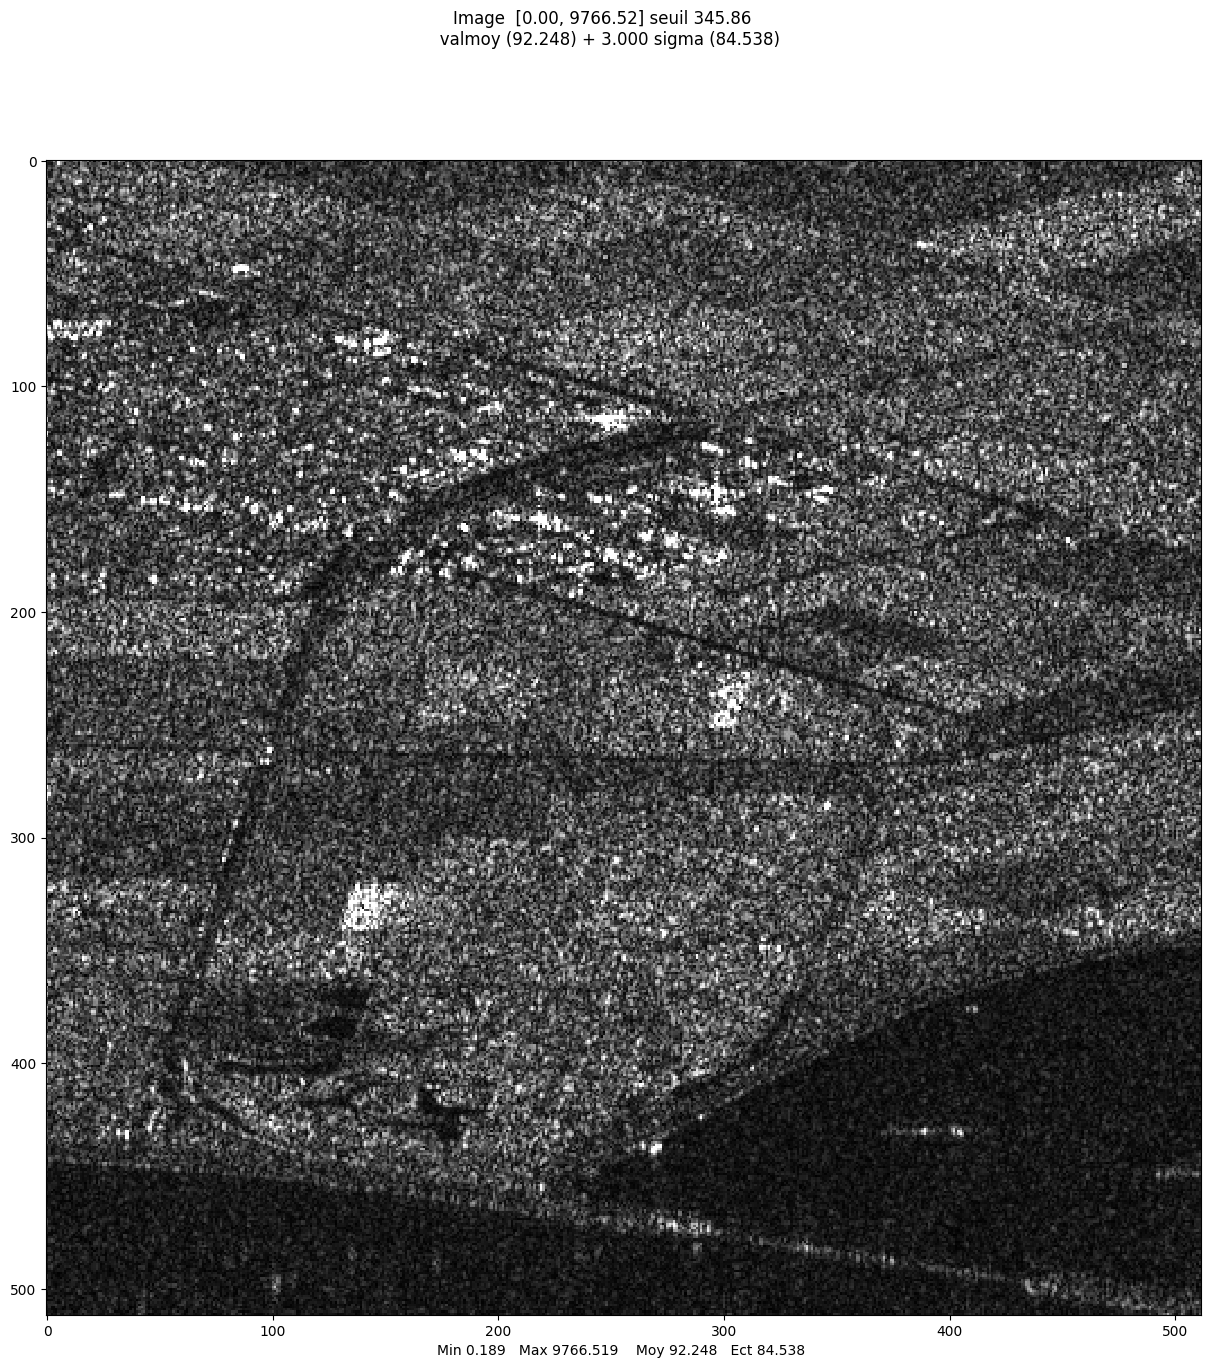

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


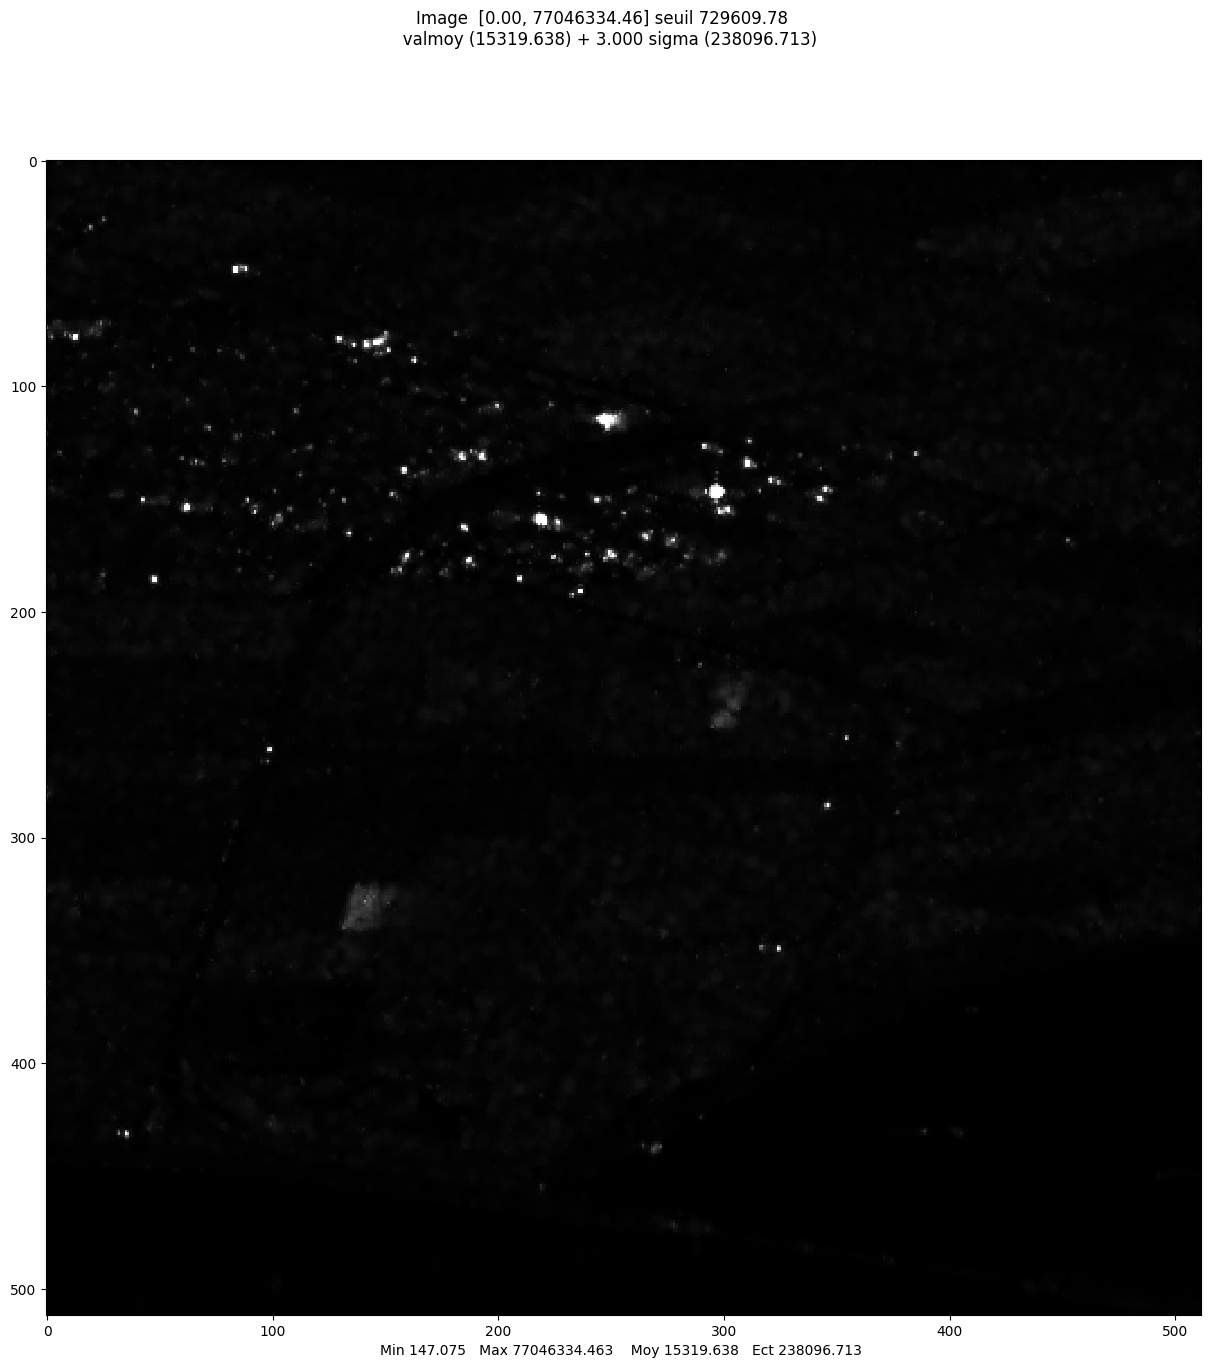

array([[ 4745.95183036,  3482.11389508,  6181.22979844, ...,
         2269.62403954,  2505.07314212,  2296.69152948],
       [ 2158.50352968,  2844.13187055,  5900.49509072, ...,
         9062.83087442,  6899.25400553,  2263.4690402 ],
       [ 3175.65108758,  6816.8089784 , 10306.9844327 , ...,
         9963.5924295 ,  7206.60081433,  5457.58830735],
       ...,
       [  877.02047671,  1054.41457586,  1355.29401098, ...,
         5668.12622595,  5205.71698038,  3670.18472842],
       [  392.16797185,   829.0469366 ,   939.79504618, ...,
         4881.67206755,  4084.7838047 ,  4921.15127457],
       [  584.59187727,  1700.00104056,   383.66080877, ...,
         5164.52305483,  1726.15093208,  9866.01487915]])

In [14]:
part_lely_slc = mvalab.imz2mat('lely_tuple_multitemp.IMA')[0] #date is on thrid axis of part_lely_slc
part_lely_slc = part_lely_slc[:,:,0] #single look complex image
mvalab.visusar(np.abs(part_lely_slc))

# using your previous code, filter the image part_lely_int with the Lee filter
part_lely_int = np.abs(part_lely_slc)**2
part_lely_int_filtered = lee_filter(part_lely_int, neighborhood=5, L=1, visualize=False)
mvalab.visusar(part_lely_int_filtered)

In [15]:
# this image has already been processed by a CNN based filter
# !wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.IMA
# !wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.dim

url = "https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.IMA"
filename = "lely_tuple_multitemp_SAR2SAR.IMA"
urllib.request.urlretrieve(url, filename)

url = "https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.dim"
filename = "lely_tuple_multitemp_SAR2SAR.dim"
urllib.request.urlretrieve(url, filename)

('lely_tuple_multitemp_SAR2SAR.dim',
 <http.client.HTTPMessage at 0x1b4004e8990>)

imz2mat : version janvier 2018.  Fichier à ouvrir : lely_tuple_multitemp_SAR2SAR.IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
Dans ximaread : lecture du canal 0/25
image en .IMA
image en .IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
image en .ima  512   512   canaux: 25  verif :  1
512 512
-type FLOAT
lecture de  lely_tuple_multitemp_SAR2SAR.IMA  en quelconque 512 512 25  offset  0 <f 4  complex 0 blocksize 1048576
Boucle de lecture entre 0 et 25   sur 25 canaux
Lecture du canal 1/25
Données réelles. Nouvelle version de imz2mat  <f
Lecture du canal 2/25
Données réelles. Nouvelle version de imz2mat  <f
Lecture du canal 3/25
Données réelles. Nouvelle version de imz2mat  <f
Lecture du canal 4/25
Données réelles. Nouvelle version de imz2mat  <f
Lecture du canal 5/25
Données réelles. Nouvelle version de imz2mat  <f
Lecture du canal 6/25
Données réelles. Nouvell

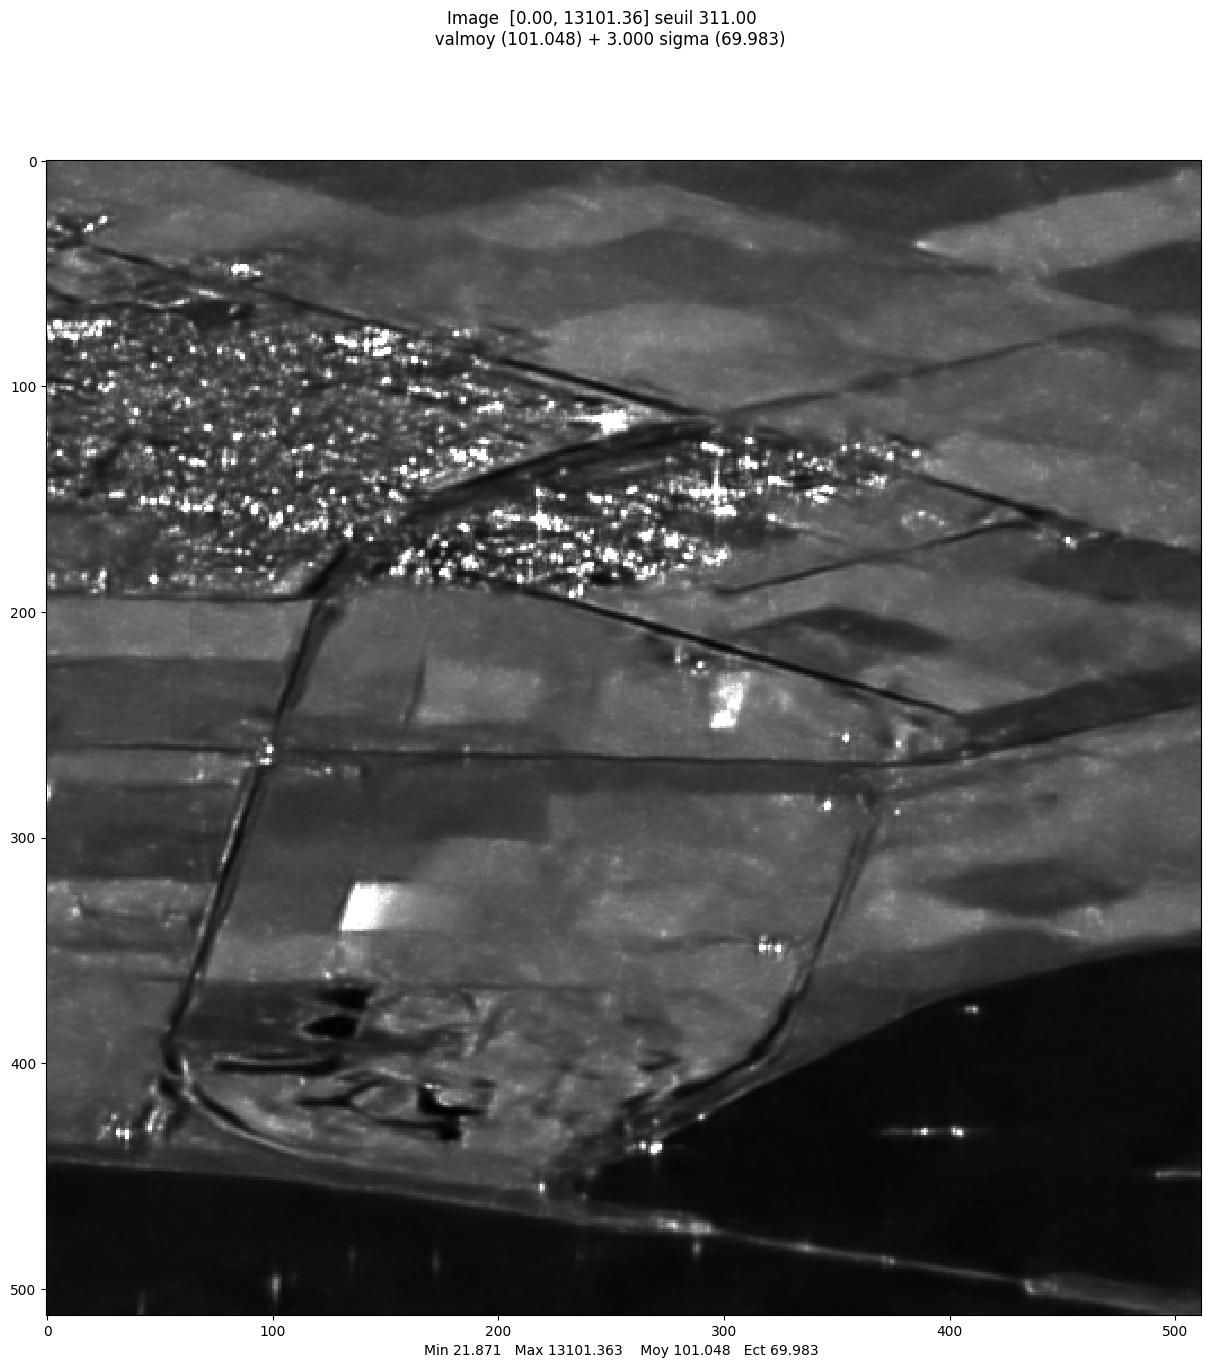

array([[108.26735687, 108.92593384, 117.21216583, ...,  87.13925171,
         89.79171753,  89.75721741],
       [105.54544067, 111.25749207, 116.15348053, ...,  95.23865509,
         96.19988251,  95.58480072],
       [105.72384644, 114.29315186, 116.50016022, ..., 100.59217072,
        100.78230286, 100.22771454],
       ...,
       [ 40.31035233,  38.88003159,  38.09856415, ...,  82.76222992,
         81.49038696,  81.83437347],
       [ 39.99552917,  38.5390358 ,  38.96235657, ...,  84.42482758,
         84.06273651,  83.64545441],
       [ 40.69298935,  38.59126282,  38.61891174, ...,  81.21070862,
         82.10493469,  87.46295166]])

In [16]:
im_lely_multitemp_denoised = mvalab.imz2mat('lely_tuple_multitemp_SAR2SAR.IMA')
im1_d = np.abs(im_lely_multitemp_denoised[0][:,:,0]) #amplitude
mvalab.visusar(im1_d)

### Question C.4
Do a comparison between the CNN filtering and the Lee filter. Comment the two results. Are homogeneous areas well restored? Do the methods preserve edges and fine structures? Are artifacts introduced?

### Answer C.4

## C.5 Method noise
Performances of a denoising algorithm can be visually interpreted by looking at the *residual noise* (i.e. the ratio between the noisy image and the denoised image, in intensity). For a quantitative evaluation, we can look at the noise statistics, knowing that, in intensity, statistics of speckle S are:
- $\mu_S=1$
- $\sigma^2_S = \frac{1}{L}$

### Question C.5
Compute the aforementioned ratio image, mean value and variance for the image restored using the Lee filter and the result of SAR2SAR. Comment the results.

What is the interest of computing the method noise ? What are your conclusions for the two previous filters ?

### Answer C.5

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


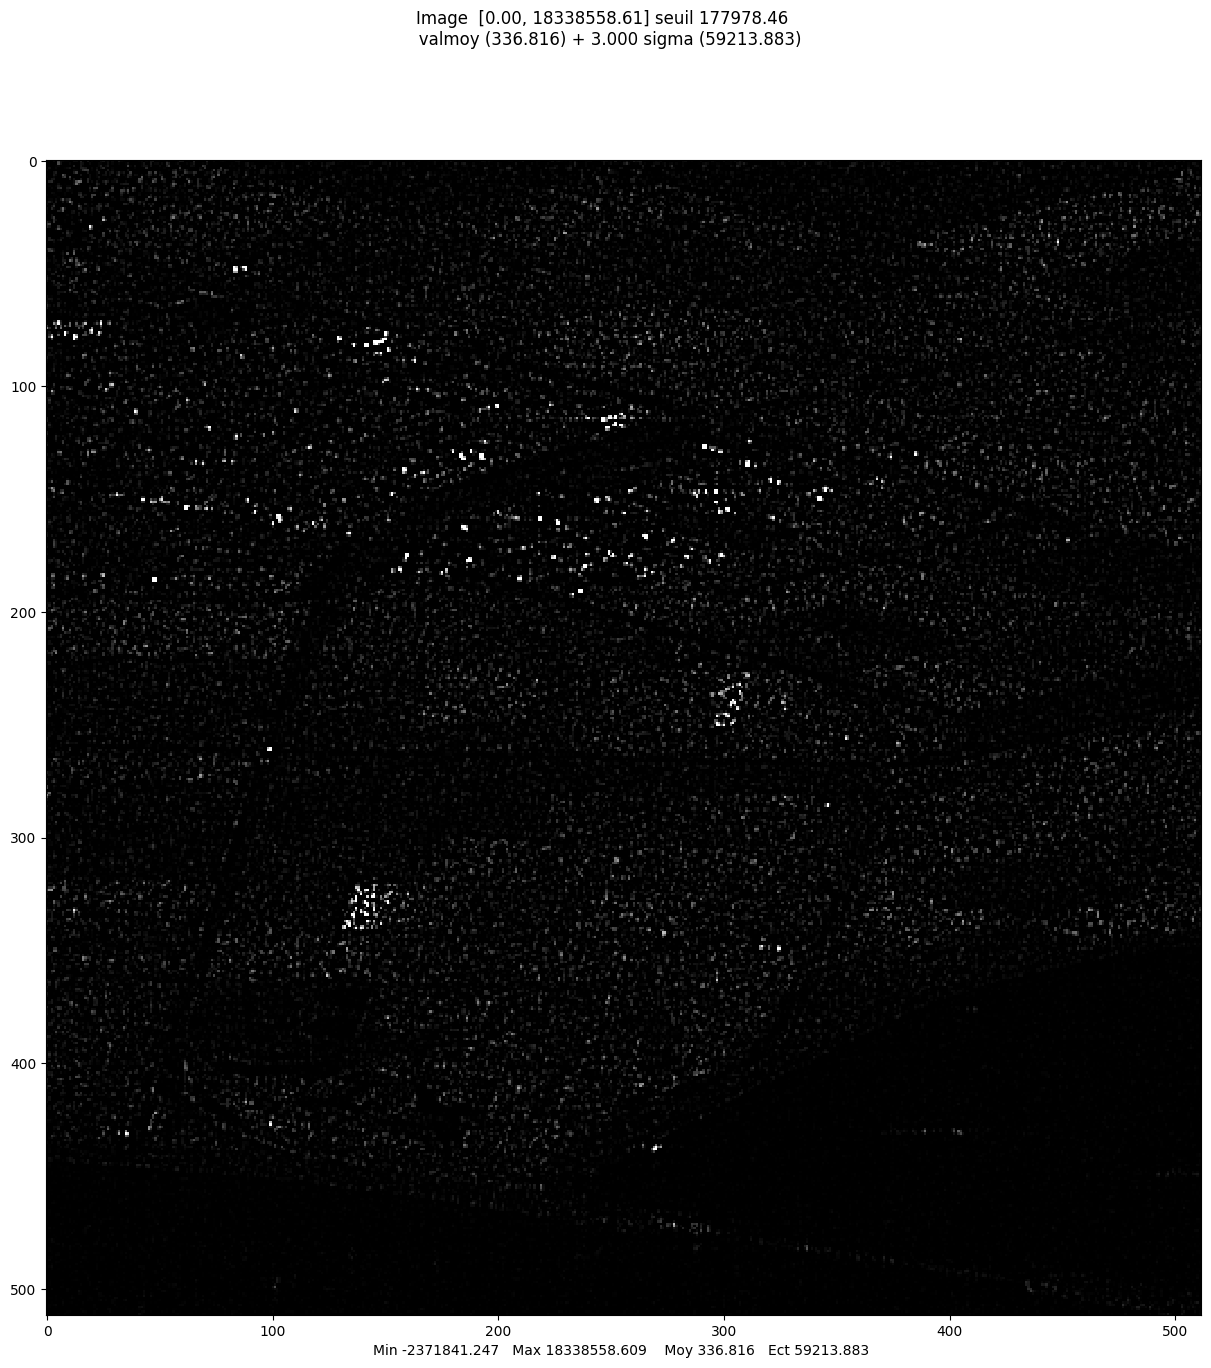

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


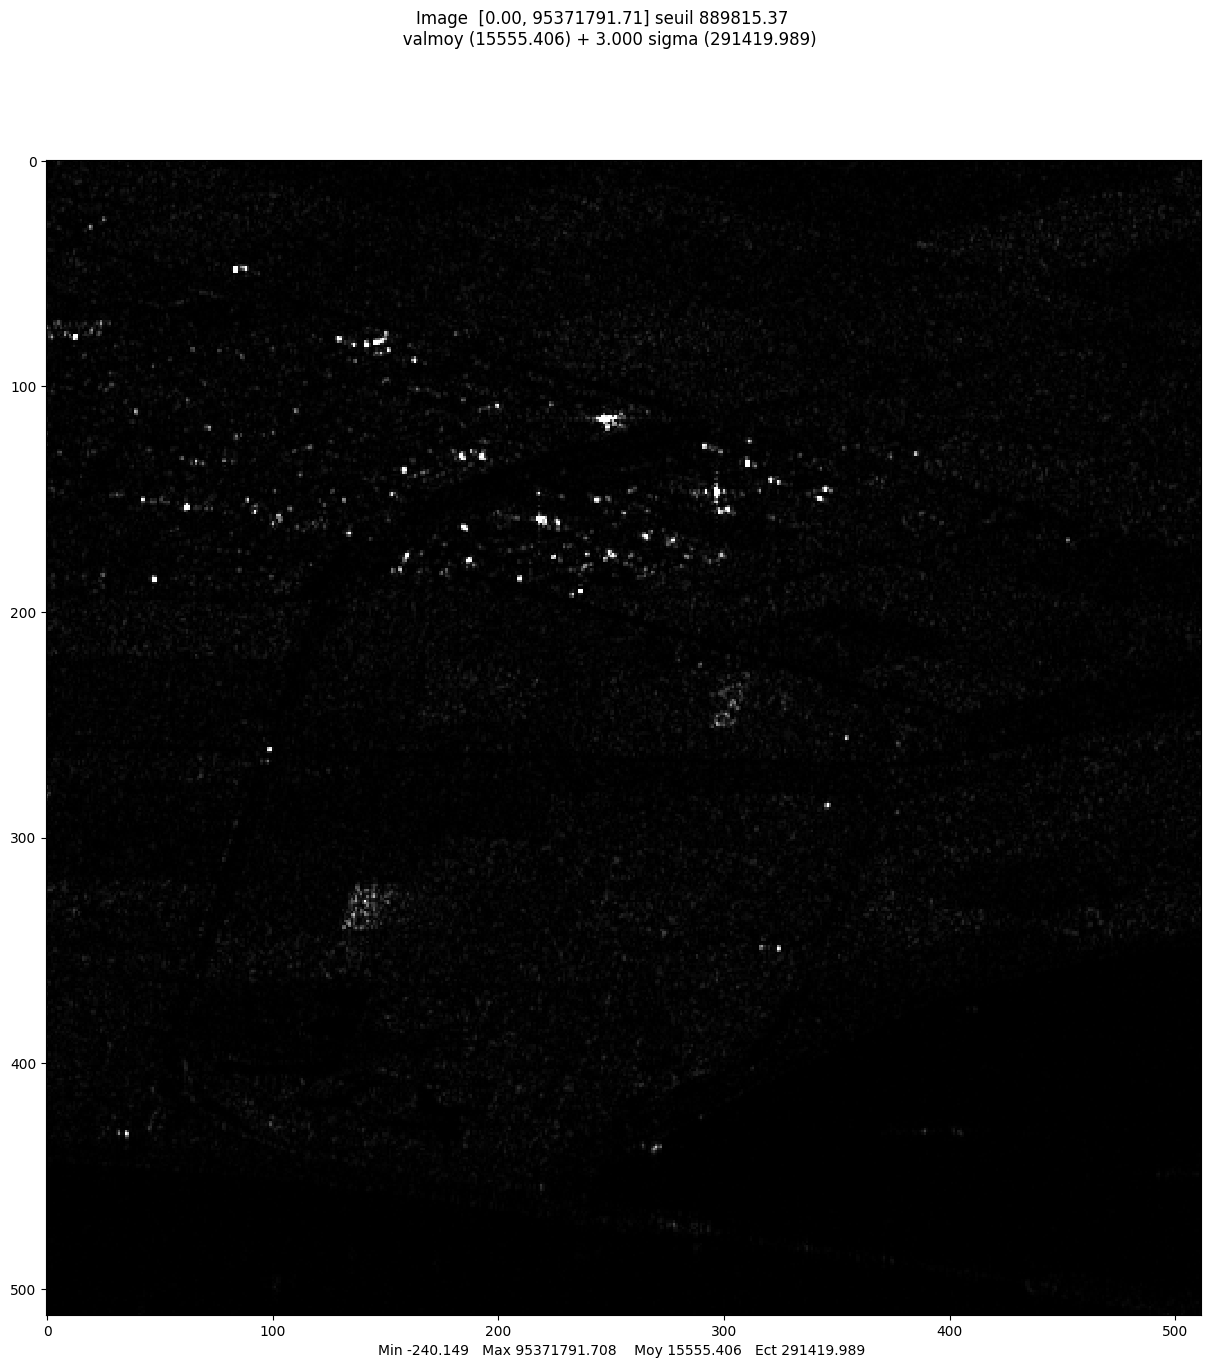

LEE FILTER: mean = 336.8157053549678 and var = 3506283887.685545
SAR2SAR: mean = 15555.405885276045 and var = 84925609802.92584


In [17]:
# Plot the residual noise
res_noise_lee = part_lely_int - part_lely_int_filtered
mvalab.visusar(res_noise_lee)
mean_lee = np.mean(res_noise_lee)
var_lee = np.var(res_noise_lee)

res_noise_deep = part_lely_int - im1_d
mvalab.visusar(res_noise_deep)
mean_deep = np.mean(res_noise_deep)
var_deep = np.var(res_noise_deep)

print('LEE FILTER: mean = '+str(mean_lee)+' and var = '+str(var_lee))
print('SAR2SAR: mean = '+str(mean_deep)+' and var = '+str(var_deep))